In [1]:
import torch as t
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"\n\nTraining samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.02MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.70MB/s]



Training samples: 60000
Test samples: 10000


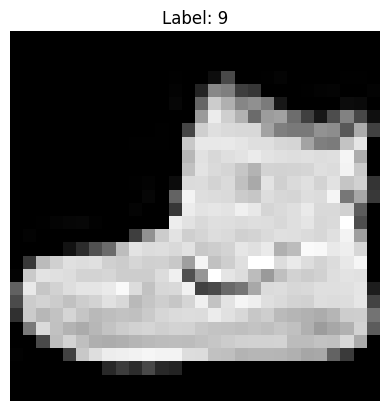

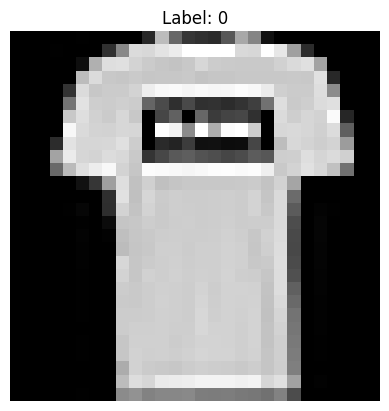

In [2]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

image2, label2 = train_dataset[1]

plt.imshow(image2.squeeze(), cmap='gray')
plt.title(f"Label: {label2}")
plt.axis('off')
plt.show()


In [3]:
import torch.nn as nn

class Fashion_MLP(nn.Module):
    def __init__(self):
        super(Fashion_MLP, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 128)
        self.final = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

model = Fashion_MLP()
print(model)


Fashion_MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [4]:
cross_entr_l = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = cross_entr_l(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = t.argmax(output, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")

Epoch [1/10] Loss: 0.5008
Epoch [2/10] Loss: 0.3712
Epoch [3/10] Loss: 0.3318
Epoch [4/10] Loss: 0.3063
Epoch [5/10] Loss: 0.2849
Epoch [6/10] Loss: 0.2687
Epoch [7/10] Loss: 0.2575
Epoch [8/10] Loss: 0.2448
Epoch [9/10] Loss: 0.2317
Epoch [10/10] Loss: 0.2204


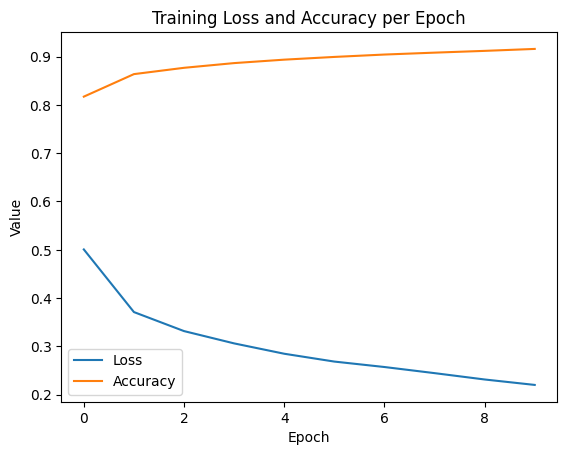

In [5]:
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Loss and Accuracy per Epoch')
plt.show()

In [8]:
correct = 0
total = 0

with t.no_grad():
    for data in train_loader:
        x, y = data
        output = model(x)
        for idx, i in enumerate(output):
            if t.argmax(i) == y[idx]:
                correct += 1
            total += 1

print(f'Training Accuracy: {round(correct/total, 3)*100}%')

correct = 0
total = 0

with t.no_grad():
    for data in test_loader:
        x, y = data
        output = model(x)
        for idx, i in enumerate(output):
            if t.argmax(i) == y[idx]:
                correct += 1
            total += 1

print(f'Test Accuracy: {round(correct/total, 3)*100}%')

Training Accuracy: 91.8%
Test Accuracy: 88.2%


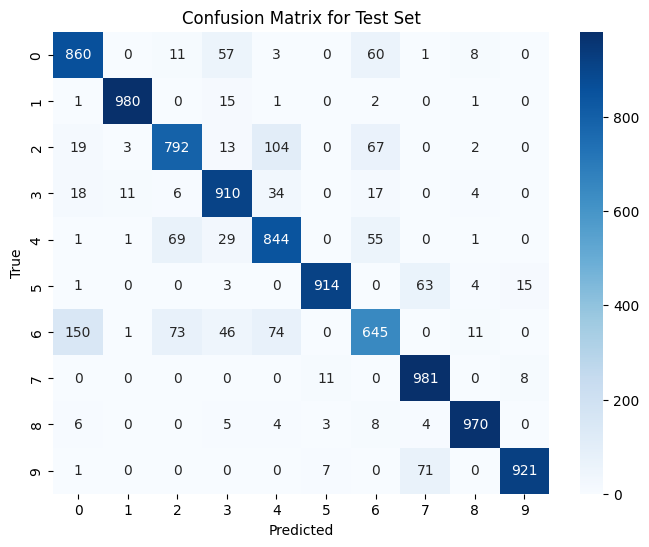

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with t.no_grad():
    for x, y in test_loader:
        output = model(x)
        preds = t.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()


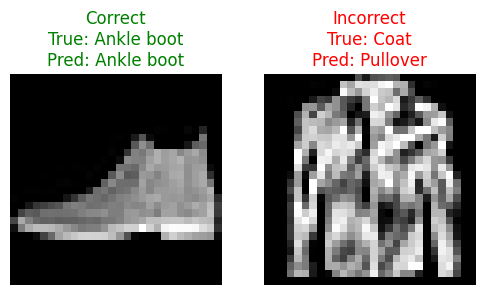

In [12]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

correct_sample = None
incorrect_sample = None

with t.no_grad():
    for image, label in test_dataset:
        image_input = image.view(1, 1, 28, 28)
        output = model(image_input)
        pred = t.argmax(output, dim=1).item()

        if pred == label and correct_sample is None:
            correct_sample = (image, label, pred)
        elif pred != label and incorrect_sample is None:
            incorrect_sample = (image, label, pred)

        if correct_sample and incorrect_sample:
            break

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(correct_sample[0].view(28, 28), cmap='gray')
axes[0].set_title(f"Correct\nTrue: {classes[correct_sample[1]]}\nPred: {classes[correct_sample[2]]}", color='green')
axes[0].axis('off')

axes[1].imshow(incorrect_sample[0].view(28, 28), cmap='gray')
axes[1].set_title(f"Incorrect\nTrue: {classes[incorrect_sample[1]]}\nPred: {classes[incorrect_sample[2]]}", color='red')
axes[1].axis('off')

plt.show()



**Conclusion**

The MLP model demonstrated steady convergence and achieved a test accuracy exceeding 85%.

The loss consistently decreased across epochs, indicating stable training.

Overall, the network effectively classified Fashion-MNIST images using a simple fully connected architecture.